# **A Primer On Neural Cellular Automata**

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL, einops
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

## **Background on Neural Cellular Automata(NCA)**

We'll be continuing with Johnathan Whitaker's excellent deep dives from [lesson 20](https://www.youtube.com/watch?v=PdNHkTLU2oQ&t=72s). 

This notebook covers the fascinating topic of [Neural Cellular Automata](https://distill.pub/2020/growing-ca/). In his notes, Johno's summary of NCA is:

> A cellular automaton is a discrete model that consists of a grid of cells, each of which can be in one of a finite number of states. The cells are updated simultaneously based on a set of rules that determine the state of a cell based on the states of its neighbors.
>
>Cellular automata are often used to model complex systems and can exhibit emergent behavior, meaning that patterns and >behaviors emerge from the interactions of the individual cells even though the rules governing their behavior are simple.
>
>Classic examples such as the famous 'Game of Life' have very simple rules and limit states to 'alive' or 'dead'. However, >the ideas can be extended to continuous outputs for each cell, and the update 'rule' can be a small neural network rather than a hard-coded decision tree - giving us 'Neural Cellular Automata'.


For additional reading, he also included links to the following papers, discussions and posts:

>Key references: 
>- [Growing Neural Cellular Automata](https://distill.pub/2020/growing-ca/) - A delightful paper that was my intro to the topic
>- [Texture Generation with NCA](https://arxiv.org/abs/2105.07299) - tiny models making amazing >textures, the paper we're replicating today.
>- ['The Future of Artificial Intelligence is Self-Organizing and Self-Assembling'](https://sebastianrisi.com/self_assembling_ai/) - More general discussion of this space
>- [Fixing Neural CA Colors with Sliced Optimal Transport](https://www.youtube.com/watch?v=ZFYZFlY7lgI) -  A follow-on video from Alexander Mordvintsev (include code for a different style loss)
>- [Fun with Neural Cellular Automata](https://wandb.ai/johnowhitaker/nca/reports/Fun-with-Neural-Cellular-Automata--VmlldzoyMDQ5Mjg0) - My W&B report with lots of examples

## **Style Matching with NCA**

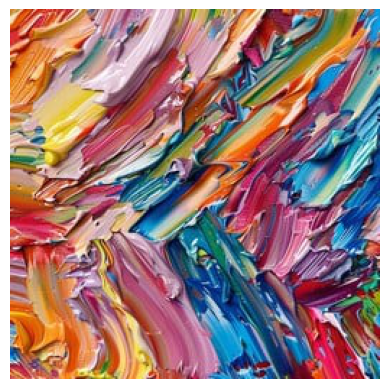

In [2]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

url = "https://images.stockcake.com/public/d/4/8/d483ae6d-f7f9-43c4-825b-55c0c8cf08e5_medium/vibrant-paint-strokes-stockcake.jpg"
style_im = download_image(url).to(def_device)
show_image(style_im);

### **Style Loss From NB_16A**

In [9]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[15, 25]):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

# Using the batched version of the Gram matrix function
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
             for x in calc_features(img, target_layers))

class StyleLossToTarget():
    # This version assigns layers with the same weight. We can experiment with passing
    # a vector of weights for each layer. 
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im[None], target_layers)

    def __call__(self, input_im):
        return sum((f1 - f2).pow(2).mean() for f1, f2 in 
                   zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [8]:
style_loss = StyleLossToTarget(style_im)
# We can feed in a new image or batch of images to get the loss.
style_loss(torch.rand(1, 3, 256, 256).to(def_device))

tensor(831.8683, device='cuda:0', grad_fn=<AddBackward0>)

## **Create the NCA Model**

In [5]:
num_channels = 4
hidden_n = 8

In [6]:
def make_grids(n, sz=128): return torch.zeros(n, num_channels, sz, sz).to(def_device)

For perception, we will be using some hard coded filters. This approach is taken from the paper referenced in the previous section and essentially keeps the parameter count very low. Which is pretty mind boggling, because we will be able to train a self organizing system with a few hundred parameters. The alternative is to have them be learned.

In [11]:
# Hard coded filters which define the identity and the gradients.
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
]).to(def_device)

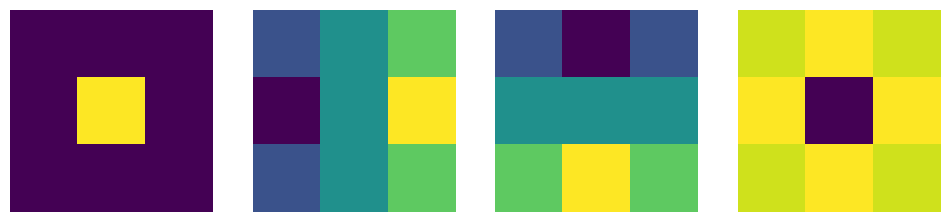

In [21]:
# Visualizing the filters, the last one is called a Soebel filter
show_images(filters, ncols=4, nrows=1)

In [24]:
def per_channel_conv(x, filters):
    '''filters:[filter_n, h, w]'''
    # Apply HC filters individually to each channel of the input, instead of a kernel 
    # which has different weights for each channel.
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # Using circular padding to deal with artifacts on edge pixels.
    y = F.conv2d(y, filters[:, None])
    return y.reshape(b, -1, h, w)

In [23]:
x = make_grids(1)
model_inputs = per_channel_conv(x, filters)
model_inputs.shape

torch.Size([1, 16, 128, 128])

This gives us 16 inputs, based on 4 channels and 4 filters, which makes up our little "brain". the 16 inputs are applied to each location in the grid.

For the next step, we will implement the neural network from the Texture Generation paper above.

In [29]:
# A linear layer style brain
brain = nn.Sequential(
    nn.Linear(num_channels*4, hidden_n),
    nn.ReLU(),
    nn.Linear(hidden_n, num_channels, bias=False) # bias=False to ensure stable updates to the networks
).to(def_device)                                  # while keeping the number of parameters low.

# einops for 'reader friendly, smart element reordering for multi-dimensional tensors.' We're rearranging our inputs
# to have 16 features, feeding them throught the linear layer and reshaping them back to match our outputs.
model_inputs_flat = einops.rearrange(model_inputs, 'b c h w -> (b h w) c') ## (1x128x128, 16)
brain_preds = brain(model_inputs_flat).reshape(x.shape)
brain_preds.shape

torch.Size([1, 4, 128, 128])

In [30]:
[p.shape for p in brain.parameters()]

[torch.Size([8, 16]), torch.Size([8]), torch.Size([4, 8])]

In [50]:
# A convolution style brain where we pass the linear network on top of each set of inputs
# while keeping the kernel size equal to 1.
brain = nn.Sequential(
    nn.Conv2d(num_channels*4, hidden_n, 1),
    nn.ReLU(),
    nn.Conv2d(hidden_n, num_channels, 1, bias=False) # 1x1 conv layer
).to(def_device)

brain_preds = brain(model_inputs).reshape(x.shape)
brain_preds.shape

torch.Size([1, 4, 128, 128])

In [51]:
# This is essentially the same operation as the linear style brain i.e. we are carrying out
# pixel level calculations.
[p.shape for p in brain.parameters()]

[torch.Size([8, 16, 1, 1]), torch.Size([8]), torch.Size([4, 8, 1, 1])]

We can now put all of the above in a class called `SimpleCA` _(CA: Cellular Automata)_.

The additional features include:
- Random updating: Only update ~50% of the cells to save compute.
- `to_rgb()` to scale and show the first 3 channels as an RGB image.
- An option to zero out the weights of the second layer. Helps to keep things conservative while improving training.

In [58]:
class SimpleCA(nn.Module):
    def __init__(self, zero_w2=True):
        super().__init__()
        self.w1 = nn.Conv2d(num_channels*4, hidden_n, 1)
        self.relu = nn.ReLU()
        self.w2 = nn.Conv2d(hidden_n, num_channels, 1, bias=False)
        if zero_w2: self.w2.weight.data.zero_() # no need for nn.init() or no_grad since we're using zero_()

    def forward(self, x, update_rate=0.5):
        y = per_channel_conv(x, filters) # Apply filters
        y = self.w2(self.relu(self.w1(y))) # pass the result through the brain
        b, c, h, w = y.shape
        update_mask = (torch.rand(b, 1, h, w).to(x.device) + update_rate).floor() # Do random update to mimic biological processes.
        return x+y * update_mask                                                  # where updates are not synchronzed

    def to_rgb(self, x):
        return x[..., :3, :, :] + 0.5

## **Model Training**

In [53]:
class LengthDataset():
    def __init__(self, length=1): self.length = length

    def __len__(self): return self.length

    def __getitem__(self, idx): return 0, 0


def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [54]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iterations
        if (len(self.losses))%64 != 10: return

        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])

        # Show preview images:
        rgb = learn.model.to_rgb(learn.preds.detach()).clip(0, 1)
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])

        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [55]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, ca, style_img_tensor, style_loss_scale=0.1, size=256,
                 step_n_min=32, step_n_max=96, batch_size=4):
        fc.store_attr()
        with torch.no_grad(): self.pool = make_grids(256, sz=size) # Setup a pool of grids

    def predict(self, learn):
        # Pick random samples from the pool
        batch_idx = torch.randint(0, len(self.pool), (self.batch_size,))
        x = self.pool[batch_idx]
        
        # Occasionally zero out some samples
        if torch.randint(8, (1,)) < 1:
            x[:1] = make_grids(1, sz=self.size)
        
        # Apply the model a number of times
        for i in range(torch.randint(self.step_n_min, self.step_n_max, (1,))):
            x = learn.model(x)

        # Update the pool
        with torch.no_grad(): self.pool[batch_idx] = x

        # store predictions
        learn.preds = x

    def get_loss(self, learn):
        style_loss = learn.loss_func(learn.model.to_rgb(self.learn.preds))
        overflow_loss = (learn.preds - learn.preds.clamp(-1.0, 1.0)).abs().sum()
        learn.loss = overflow_loss + style_loss*self.style_loss_scale

    def backward(self, learn):
        learn.loss.backward()
        # Gradient normalization
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm() + 1e-8)

    def before_fit(self, learn): self.learn = learn

In [59]:
model = SimpleCA().to(def_device)
cbs = [NCACB(model, style_im), NCAProgressCB(), MetricsCB()]
style_loss = StyleLossToTarget(style_im)

learn = Learner(model, get_dummy_dls(1500), style_loss, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
13403.343,0,train
6.271,0,eval


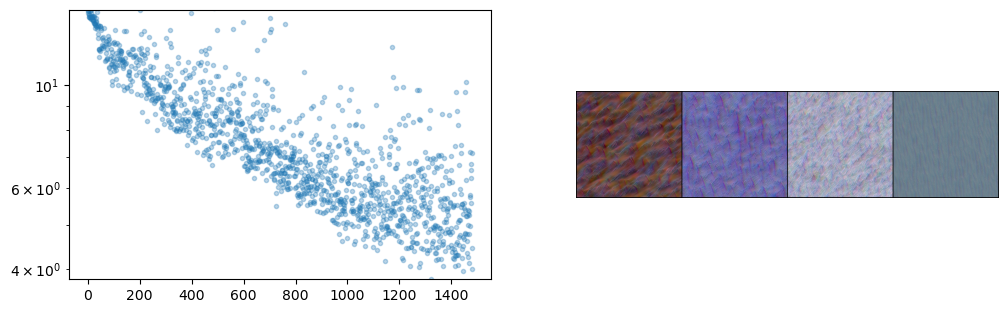

In [60]:
learn.fit(1)

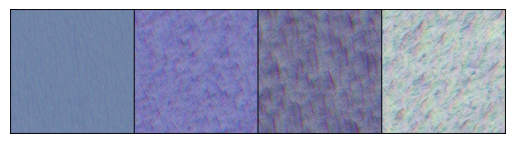

In [61]:
# The model's final batch
rgb = model.to_rgb(learn.preds.detach())
rgb = torchvision.utils.make_grid(rgb)
show_image(rgb.clip(0, 1));

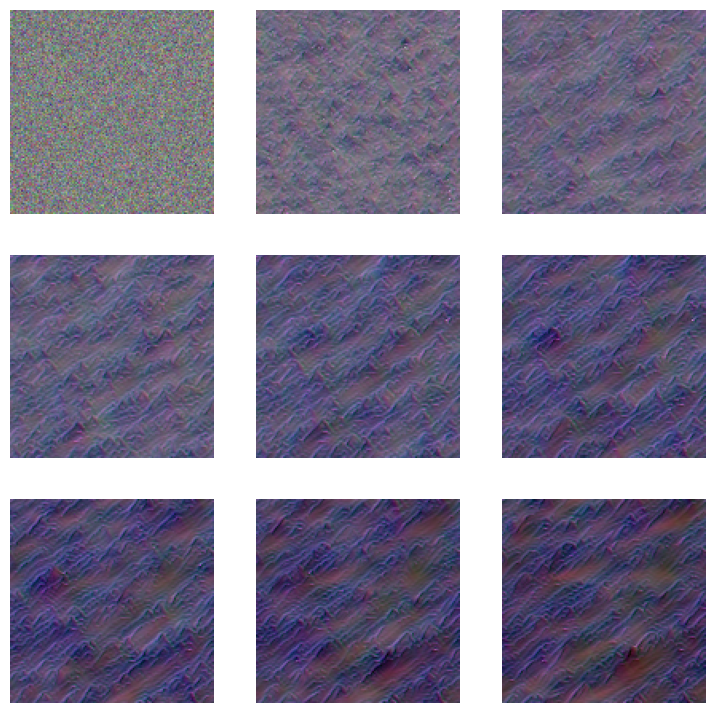

In [62]:
# Apply the process a number of times to a random initial starting grid
images = []
x = torch.randn(1, num_channels, 128, 128).to(def_device)*0.1
for i in range(900):
    x = model(x)
    if i%100==0: images.append(model.to_rgb(x)[0].clip(0, 1))

show_images(images)

In [63]:
sum(p.numel() for p in model.parameters())

168